In [ ]:
# Description: This program uses an artificial recurrent neural network calles long short term memory (LSTM)
# to predict the closing stock price of a corporation (Apple Inc. ) using the past 60 day stock price.

In [2]:
#import the libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yahooFinance
plt.style.use('fivethirtyeight')

In [3]:
#Get the stock quote
dataFrame = yahooFinance.download('AAPL', start='2012-01-01', end='2019-12-17')

#show the data
dataFrame


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.466090,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.533087,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.672228,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.804701,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.784389,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.476593,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.035072,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.203369,137310400


In [4]:
#Get the number of row and columns in the data set
dataFrame.shape

(2002, 6)

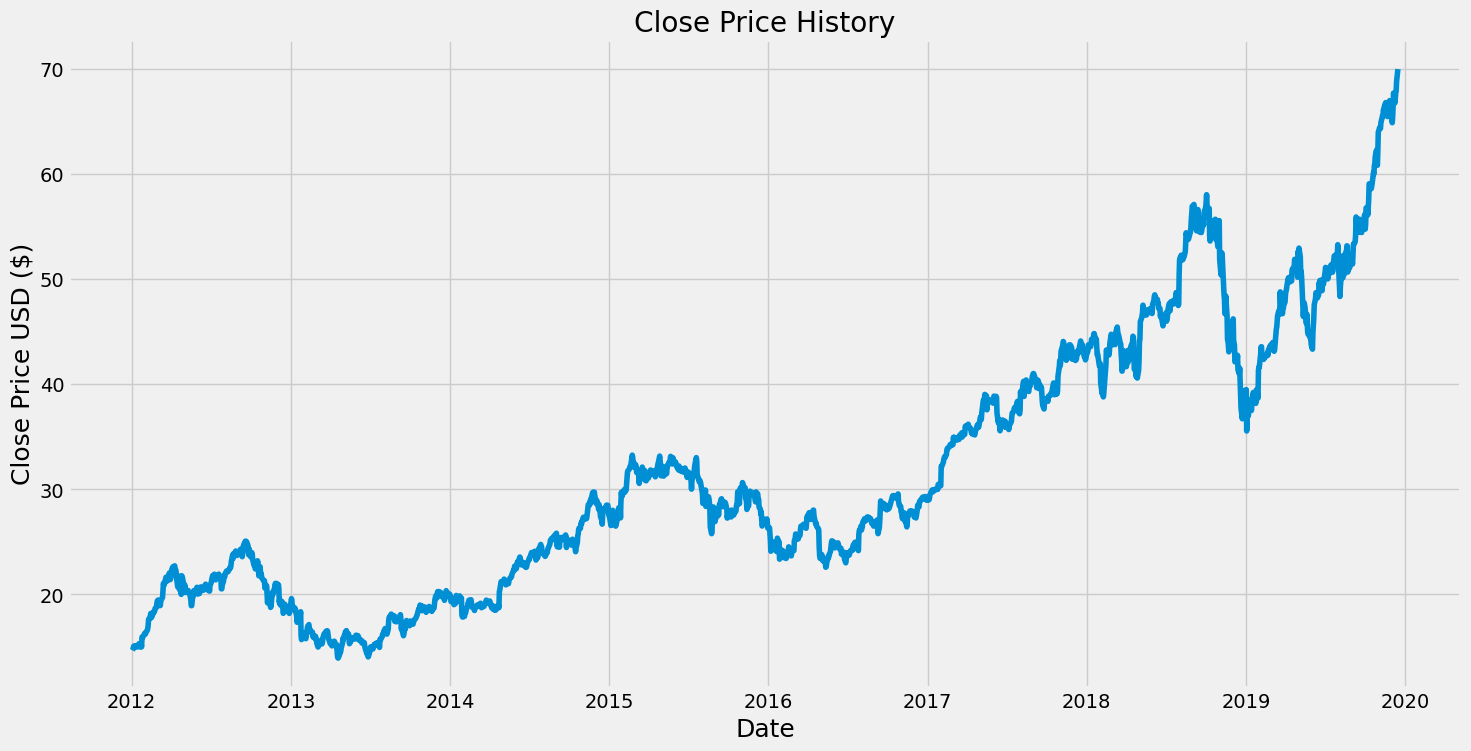

In [6]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(dataFrame['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [8]:
#Create a new data frame with only the close column
data = dataFrame.filter(['Close'])

#Convert the data frame to a numpy array
dataset = data.values

#Get the number of rows to train the model on
#We're going to train using 80% of the data, so we'll define the size as:
training_data_length = math.ceil(len(dataset) * .8)

training_data_length

1602

In [9]:
#Scale the data, in other words, normalizing the data. Here we'll leave the data between values 0 and 1.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0131974 ],
       [0.01460639],
       [0.01753278],
       ...,
       [0.96251174],
       [0.97897982],
       [1.        ]])

In [ ]:
#Create the training data set
#Create the scaled training data set

train_data = scaled_data[0:training_data_length, 0]

#Split the data into x_train and y_train data sets
x_train = [] #training variables
y_train = [] #target variable/expected result

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i])
  y_train.append(train_data[i])
  print(i)
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

#What we're doing here is "find the 61 value based on the previous 60"


In [11]:
#Convert the x_train and y_train to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data, because the LSTM model expects input in three dimensions
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #the last parameter ("1") is because we only want the closing value of the stock

x_train.shape


(1542, 60, 1)

In [12]:
#build the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1],1))) #LSTM layer
model.add(LSTM(50, return_sequences=False)) #LSTM layer
model.add(Dense(25)) #regular layer of neural networks
model.add(Dense(1)) #regular layer of neural networks


In [13]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error') #optimizer: it is to improve the loss function; loss: is the function for measuring model performance;

In [14]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1542/1542 [==============================] - 58s 35ms/step - loss: 6.4825e-04


In [18]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_length - 60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_length: , :] #values we want to predict/get right

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])


In [16]:
#Convert the data to a numpy array

x_test = np.array(x_test)

#reshape the data

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
#Get the model's predicted price values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #what we're doing here is taking the value out of the range between 0 and 1. That's de-transforming.


13/13 [==============================] - 1s 17ms/step


In [19]:
#Get the root mean squared error (RMSE), it is a good metric for assessing how good your model is.

rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse


0.5853832054138184

<ipython-input-26-fde811b8bcff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


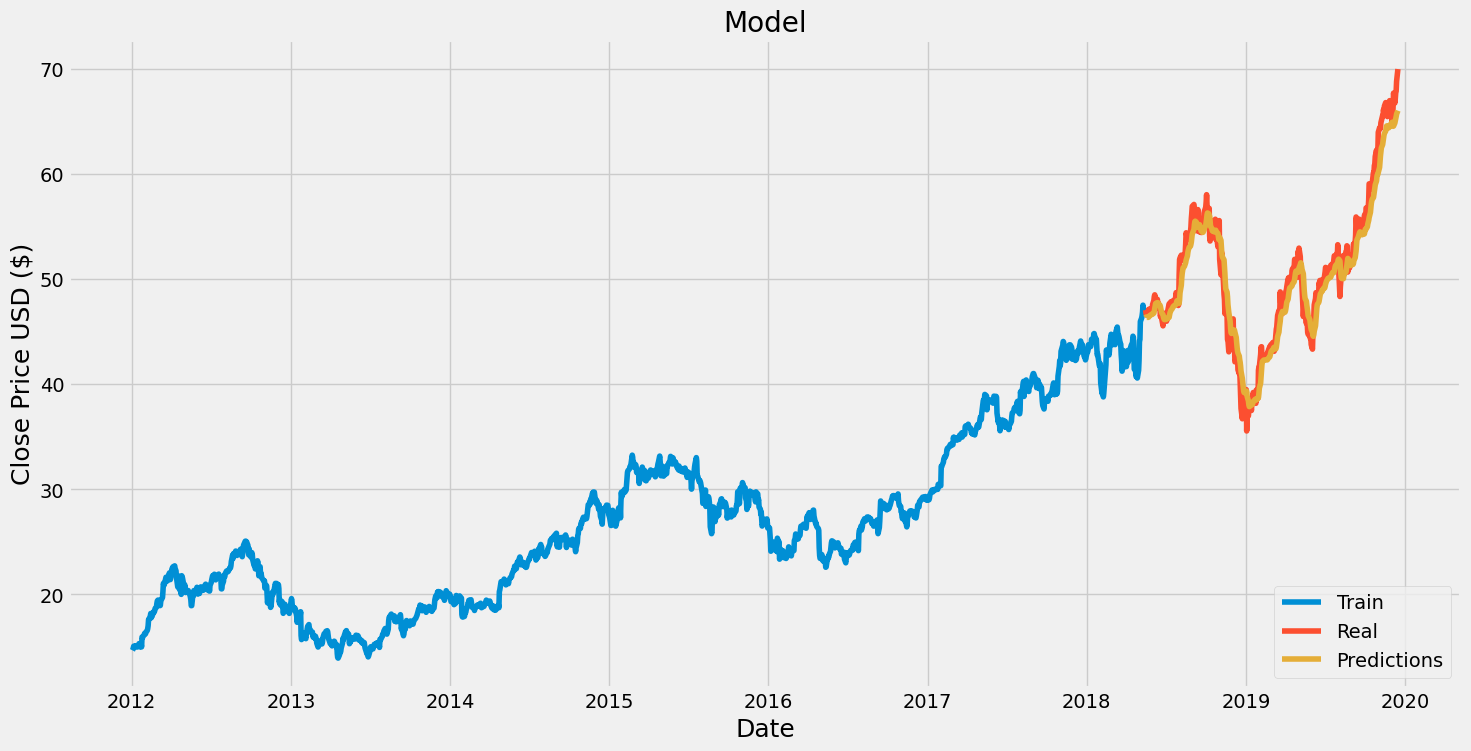

In [26]:
#Plot the data
train = data[:training_data_length]
valid = data[training_data_length:] #valid = real
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize= (16,8))
plt.title ('Model')
plt.xlabel ('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Real', 'Predictions'], loc='lower right')

In [22]:
#Show the valid and predicted prices

valid

,Close,Predictions
Date,,
2018-05-16,47.044998,46.320194
2018-05-17,46.747501,46.375851
2018-05-18,46.577499,46.380112
2018-05-21,46.907501,46.343895
2018-05-22,46.790001,46.353508
...,...,...
2019-12-10,67.120003,65.023010
2019-12-11,67.692497,65.209129
2019-12-12,67.864998,65.443970


In [25]:
#Now let's try to predict the share price on a specific day
#Get the quote
apple_quote = yahooFinance.download('AAPL', start='2012-01-01', end='2019-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X test data set to a numpy array
X_test = np.array (X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape [0], X_test.shape [1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price = scaler. inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 42ms/step
[[66.499466]]
